<a href="https://colab.research.google.com/github/ttdGit/ColabOpenApi/blob/main/OpenApiWhisperFromUTube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demostrates pip install, checking VM stuff, downloading uTube content, ffmpeg processing, process audio with Whisper OpenAPI, arrays, charting, CSV extraction,

In [ ]:
!pip install git+https://github.com/openai/whisper.git -q

     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 71.6 MB/s 
     |████████████████████████████████| 182 kB 56.0 MB/s 


We'll also make sure we have a GPU available in Google Colab. If you don't have a GPU, go to Runtime -> Change Runtime Type -> Hardware Accelator and select GPU. Run the command below to show which GPU is being used in the current runtime:
You can upgrade to Colab Pro to get access to Premium GPU's.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e8a83bfe-c3bb-abba-376d-8970bce98d5a)


install pytube to get some content

In [ ]:
!pip install pytube -q

     |████████████████████████████████| 57 kB 2.8 MB/s 


In [ ]:
import whisper
from pytube import YouTube

Whisper has a variety of models of varying sizes. The large model will be more accurate but will also be more resource intensive.

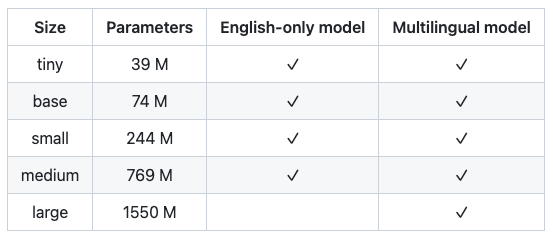

The base model will be sufficient for our needs. Let's load the base model like so:

In [ ]:
model = whisper.load_model('base')

100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 57.8MiB/s]


We'll now instantiate a "YouTube" object by passing in the video URL. This will allow us to retrieve metadata and stream info about the specified YouTube URL.

In [ ]:
youtube_video_url = "https://www.youtube.com/watch?v=NT2H9iyd-ms"
youtube_video = YouTube(youtube_video_url)

Now that we have an pytube YouTube object, let's explore some of its attributes.

In [ ]:
youtube_video.title

'WATCH LIVE | Fed Chair Powell Discusses Latest Fed Rate Hike'

In [ ]:
dir(youtube_video)

In [ ]:
youtube_video.streams

In [ ]:
for stream in youtube_video.streams:
  print(stream)

Get audio channels.

In [ ]:
streams = youtube_video.streams.filter(only_audio=True)
streams

In [ ]:
stream = streams.first()
stream
stream.download(filename='fed_meeting.mp4')

'/content/fed_meeting.mp4'

Use ffmpeg to start the audio file at the 375 second mark and continue for 2715 seconds, The result will be saved in a new file.

In [ ]:
!ffmpeg -ss 378 -i fed_meeting.mp4 -t 2715 fed_meeting_trimmed.mp4

It is possible to embed an audio player into Google Colab, but will not do this for now since I have seen the runtime get disconnected on large audio files. If you want a copy of the resulting audio, you can download it locally using the Colab the file browser.

In [ ]:
import datetime

# save a timestamp before transcription
t1 = datetime.datetime.now()
print(f"started at {t1}")

# do the transcription
output = model.transcribe("fed_meeting_trimmed.mp4")

# show time elapsed after transcription is complete.
t2 = datetime.datetime.now()
print(f"ended at {t2}")
print(f"time elapsed: {t2 - t1}")

started at 2023-01-02 23:55:41.967961
ended at 2023-01-02 23:57:31.483380
time elapsed: 0:01:49.515419


In [ ]:
output

In [ ]:
for segment in output['segments']:
  print(segment)
  second = int(segment['start'])
  second = second - (second % 5)
  print(second)

Combining Speech Data with Price Data
Now that we have this speech and the associated timestamps, we can go further by merging these segments into a dataframe containing price data. Let's see how the speech maps to the price of the S&P 500. I have retrieved 5 second OHLCV data for SPY using Interactive Brokers. A copy of this data and the code used to retrieve it are located on the website. We can upload spy.csv to Colab and process it using pandas.

In [ ]:
import pandas as pd 
spy = pd.read_csv("spy.csv")

In the dataframe below, you can see the open, high, low, and close for each 5 second time period that occurred during the speech.

In [ ]:
spy

Since we already have the segments of the speech and their start and end times in seconds, we can add a new column containing the text that was spoken during each 5 second bar.

In [ ]:
for segment in output['segments']:
   second = int(segment['start'])
   second = second - (second % 5)
   spy.loc[second / 5, 'text'] = segment['text']

spy

Let's also create a new column called percent that stores the percent the price moved during the 5 second period.

In [ ]:
spy['percent'] = ((spy['close'] - spy['open']) / spy['open']) * 100
spy

We can now filter our dataframe to show bars where the price moved more than a certain percentage. To see where price moved down substantially in a 5 second period, we can filter like so:

In [ ]:
big_downmoves = spy[spy.percent < -0.2]
big_downmoves


Let's quickly visualize this and zoom in on 14:36 using mplfinance:

In [ ]:
!pip install mplfinance -q
import mplfinance as mpf

df = spy
df.index = pd.DatetimeIndex(df['date'])

mpf.plot(df['2022-11-02 14:36':'2022-11-02 14:39'],type='candle')


As we can see above, price moved significantly starting at 14:36 (row 61), so we can see the words spoken that led up to this:

In [ ]:
spy[50:70]